# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import warnings
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, GRU
import itertools
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

# Data Loading And Preprocessing

In [ ]:
# Try to load the dataset from the local file, If not possible, then defaults to google drive version
def getfile(location_pair,**kwargs):
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out

fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
raw_data=getfile(fname)
raw_data.head()

local file not found; accessing Google Drive


,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate
0,State,California,01/01/1976,1976,January,N,Final,9672362,8668016,1004346,0.104
1,State,California,01/01/1976,1976,January,Y,Final,9774280,8875685,898595,0.092
2,County,Los Angeles County,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.096
3,County,Los Angeles County,01/01/1976,1976,January,Y,Final,3381856,3081806,300050,0.089
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.096


In [ ]:
raw_data['Date']= pd.to_datetime(raw_data['Date'])
raw_data['ts'] = raw_data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
raw_data['Employment Rate']=raw_data['Employment ']/raw_data['Labor Force']
raw_data.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.104,189302400000000000,0.896163
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.092,189302400000000000,0.908065
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.096,189302400000000000,0.903663
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.089,189302400000000000,0.911277
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.096,189302400000000000,0.903663


In [ ]:
#Loading the necessary columns
raw_data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
subData_State = raw_data.loc[(raw_data['Area Type']=='State')]

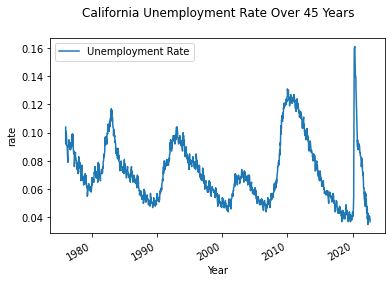

In [ ]:
# Checking a plot of unemployment rate over the years

graphPlotter = subData_State[['Date','Unemployment Rate']]
graphPlotter.set_index(["Date"], inplace=True)
graphPlotter.plot(title="California Unemployment Rate Over 45 Years\n", ylabel="rate", xlabel="Year")

In [ ]:
subData_State.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 0 to 178345
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Area Type                     1122 non-null   object        
 1   Area Name                     1122 non-null   object        
 2   Date                          1122 non-null   datetime64[ns]
 3   Year                          1122 non-null   int64         
 4   Month                         1122 non-null   object        
 5   Seasonally Adjusted (Y/N)     1122 non-null   object        
 6   Status (Preliminary / Final)  1122 non-null   object        
 7   Labor Force                   1122 non-null   int64         
 8   Employment                    1122 non-null   int64         
 9   Unemployment                  1122 non-null   int64         
 10  Unemployment Rate             1122 non-null   float64       
 11  ts                          

In [ ]:
graphPlotter.head()

,Unemployment Rate
Date,
1976-01-01,0.104
1976-01-01,0.092
1977-01-01,0.099
1977-01-01,0.092
1978-01-01,0.083


Normalization of Data and splitting of data & converting into time step data for time series forcasting

In [ ]:
model_data = graphPlotter.reset_index()['Unemployment Rate']
model_data.head()

0    0.104
1    0.092
2    0.099
3    0.092
4    0.083
Name: Unemployment Rate, dtype: float64

In [ ]:
# using sklearn MinMaxScaler for normalizing thr data
scaler=MinMaxScaler(feature_range=(0,1))
model_data_normalized=scaler.fit_transform(np.array(model_data).reshape(-1,1))
model_data_normalized

array([[0.54761905],
       [0.45238095],
       [0.50793651],
       ...,
       [0.45238095],
       [0.1031746 ],
       [0.18253968]])

In [ ]:
training_size=int(len(model_data_normalized)*0.65)
test_size=len(model_data_normalized)-training_size
train_data,test_data=model_data_normalized[0:training_size,:],model_data_normalized[training_size:len(model_data_normalized),:1]
print(training_size,test_size)

729 393


In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape, y_train.shape)
print(X_test.shape, ytest.shape)

(628, 100) (628,)
(292, 100) (292,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#Traing Model using LSTM

In [ ]:
#First model
model = Sequential()
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error')

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=32,verbose=1)

Epoch 1/20
20/20 [==============================] - 7s 133ms/step - loss: 0.0398 - val_loss: 0.0276
Epoch 2/20
20/20 [==============================] - 2s 78ms/step - loss: 0.0314 - val_loss: 0.0226
Epoch 3/20
20/20 [==============================] - 2s 77ms/step - loss: 0.0272 - val_loss: 0.0184
Epoch 4/20
20/20 [==============================] - 2s 77ms/step - loss: 0.0242 - val_loss: 0.0162
Epoch 5/20
20/20 [==============================] - 2s 77ms/step - loss: 0.0227 - val_loss: 0.0168
Epoch 6/20
20/20 [==============================] - 2s 79ms/step - loss: 0.0225 - val_loss: 0.0190
Epoch 7/20
20/20 [==============================] - 2s 77ms/step - loss: 0.0218 - val_loss: 0.0269
Epoch 8/20
20/20 [==============================] - 2s 76ms/step - loss: 0.0219 - val_loss: 0.0143
Epoch 9/20
20/20 [==============================] - 2s 77ms/step - loss: 0.0207 - val_loss: 0.0166
Epoch 10/20
20/20 [==============================] - 2s 76ms/step - loss: 0.0204 - val_loss: 0.0133
Epoch 11

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

10/10 [==============================] - 0s 17ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
ytest = scaler.inverse_transform(np.array(ytest).reshape(-1,1))

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.28709185326221215

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.01212347348689464

# Hyper-Parameter Tuning with mini batch training 


using 3 optimizers

## Using Adam optimizer

In [ ]:

def LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout))

        if first_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if second_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if third_additional_layer:
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units=1, activation='linear'))

        
        model.compile( 'Adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        model.fit(X_train, y_train, validation_split=0.3, epochs=16, batch_size=n_batch_size, callbacks=[early_stopping, model_checkpoint], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        test_accuracy = model.evaluate(X_test, ytest, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [ ]:
config = [[True], [False], [False], [16, 32], [4, 8, 16], [0.2]]

#['RMSprop', 'Adam', 'Adagrad']

#list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest)  # change x_train shape

[(True, False, False, 16, 4, 0.2), (True, False, False, 16, 8, 0.2), (True, False, False, 16, 16, 0.2), (True, False, False, 32, 4, 0.2), (True, False, False, 32, 8, 0.2), (True, False, False, 32, 16, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.03891, saving model to best_model.h5

Epoch 2: val_loss improved from 0.03891 to 0.03288, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.03288

Epoch 4: val_loss improved from 0.03288 to 0.02922, saving model to best_model.h5

Epoch 5: val_loss improved from 0.02922 to 0.02688, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.02688

Epoch 7: val_loss improved from 0.02688 to 0.02592, saving model to best_model.h5

Epoch 8: val_loss improved from 0.02592 to 0.02477, saving model to best_model.h5

Epoch 9: val_loss improved from 0.02477 to 0.02440, saving model to best_model.h5

Epoch 10: val_loss improved f

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
1,True,False,False,16,8,0.2,"[0.024296879768371582, 0.155874565243721]","[0.04204556345939636, 0.20505015552043915]"
3,True,False,False,32,4,0.2,"[0.01524004340171814, 0.12345056980848312]","[0.04635889083147049, 0.21531115472316742]"
4,True,False,False,32,8,0.2,"[0.01869172416627407, 0.13671767711639404]","[0.048098187893629074, 0.21931299567222595]"
0,True,False,False,16,4,0.2,"[0.019265873357653618, 0.13880155980587006]","[0.049662332981824875, 0.2228504717350006]"
5,True,False,False,32,16,0.2,"[0.020254669710993767, 0.14231890439987183]","[0.07454673200845718, 0.2730324864387512]"
2,True,False,False,16,16,0.2,"[0.024292223155498505, 0.15585961937904358]","[0.07642006129026413, 0.2764417827129364]"


In [ ]:
results = model.evaluate(X_test, ytest)

10/10 [==============================] - 1s 19ms/step - loss: 0.0473


In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tuning:\n Test Set RMSE: {np.round(results, 4)}\n')
print(f'Results After Tuning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)}\n')

Best Combination: 
 first_additional_layer = True
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 16
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0473

Results After Tunning:
 Test Set RMSE: [0.0445 0.211 ]



## Using Adagrad optimizer


In [ ]:
def LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout))

        if first_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if second_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if third_additional_layer:
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units=1, activation='linear'))

        
        model.compile( 'Adagrad', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        model.fit(X_train, y_train, validation_split=0.3, epochs=16, batch_size=n_batch_size, callbacks=[early_stopping, model_checkpoint], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        test_accuracy = model.evaluate(X_test, ytest, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [ ]:
config = [[True], [False], [False], [16, 32], [4, 8, 16], [0.2]]

#['RMSprop', 'Adam', 'Adagrad']

#list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest)  # change x_train shape

[(True, False, False, 16, 4, 0.2), (True, False, False, 16, 8, 0.2), (True, False, False, 16, 16, 0.2), (True, False, False, 32, 4, 0.2), (True, False, False, 32, 8, 0.2), (True, False, False, 32, 16, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.04979, saving model to best_model.h5

Epoch 2: val_loss improved from 0.04979 to 0.03760, saving model to best_model.h5

Epoch 3: val_loss improved from 0.03760 to 0.03561, saving model to best_model.h5

Epoch 4: val_loss improved from 0.03561 to 0.03486, saving model to best_model.h5

Epoch 5: val_loss improved from 0.03486 to 0.03475, saving model to best_model.h5

Epoch 6: val_loss improved from 0.03475 to 0.03466, saving model to best_model.h5

Epoch 7: val_loss improved from 0.03466 to 0.03461, saving model to best_model.h5

Epoch 8: val_loss improved from 0.03461 to 0.03456, saving model to best_model.h5

Epoch 9: val_loss improved from 0.03456 to

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
2,True,False,False,16,16,0.2,"[0.03252781182527542, 0.18035468459129333]","[0.04450133815407753, 0.21095339953899384]"
1,True,False,False,16,8,0.2,"[0.031671538949012756, 0.17796500027179718]","[0.04842395335435867, 0.22005443274974823]"
5,True,False,False,32,16,0.2,"[0.032932382076978683, 0.1814728081226349]","[0.04888056591153145, 0.22108949720859528]"
0,True,False,False,16,4,0.2,"[0.032101985067129135, 0.17917026579380035]","[0.049034446477890015, 0.2214372307062149]"
4,True,False,False,32,8,0.2,"[0.03207144886255264, 0.17908503115177155]","[0.049596790224313736, 0.22270336747169495]"
3,True,False,False,32,4,0.2,"[0.031417105346918106, 0.17724871635437012]","[0.04960188269615173, 0.22271479666233063]"


In [ ]:
results = model.evaluate(X_test, ytest)

10/10 [==============================] - 0s 18ms/step - loss: 0.0473


In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)}\n')

Best Combination: 
 first_additional_layer = True
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 16
 dropout = 0.2
**************************
Results After Tunning:
 Test Set RMSE: [0.0445 0.211 ]



## Using RMSprop optimizer

In [ ]:

def LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout))

        if first_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if second_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if third_additional_layer:
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units=1, activation='linear'))

        
        model.compile( 'RMSprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        model.fit(X_train, y_train, validation_split=0.3, epochs=16, batch_size=n_batch_size, callbacks=[early_stop, model_checkpoint], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        test_accuracy = model.evaluate(X_test, ytest, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [ ]:
config = [[True], [False], [False], [16, 32], [4, 8, 16], [0.2]]

#['RMSprop', 'Adam', 'Adagrad']

#list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest)  # change x_train shape

[(True, False, False, 16, 4, 0.2), (True, False, False, 16, 8, 0.2), (True, False, False, 16, 16, 0.2), (True, False, False, 32, 4, 0.2), (True, False, False, 32, 8, 0.2), (True, False, False, 32, 16, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.03418, saving model to best_model.h5

Epoch 2: val_loss improved from 0.03418 to 0.03103, saving model to best_model.h5

Epoch 3: val_loss improved from 0.03103 to 0.02796, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.02796

Epoch 5: val_loss improved from 0.02796 to 0.02628, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.02628

Epoch 7: val_loss did not improve from 0.02628

Epoch 8: val_loss improved from 0.02628 to 0.02437, saving model to best_model.h5

Epoch 9: val_loss improved from 0.02437 to 0.02313, saving model to best_model.h5

Epoch 10: val_loss improved from 0.02313 to 0.02274, saving mode

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
0,True,False,False,16,4,0.2,"[0.019425850361585617, 0.1393766552209854]","[0.04339641332626343, 0.2083180546760559]"
1,True,False,False,16,8,0.2,"[0.02362865023314953, 0.15371613204479218]","[0.04656771570444107, 0.21579554677009583]"
3,True,False,False,32,4,0.2,"[0.011790802702307701, 0.10858546197414398]","[0.06113841384649277, 0.24726183712482452]"
4,True,False,False,32,8,0.2,"[0.01622249186038971, 0.1273675411939621]","[0.06199387460947037, 0.24898569285869598]"
2,True,False,False,16,16,0.2,"[0.02388612926006317, 0.15455138683319092]","[0.0656777173280716, 0.2562766373157501]"
5,True,False,False,32,16,0.2,"[0.02144523523747921, 0.14644192159175873]","[0.08240720629692078, 0.2870665490627289]"


In [ ]:
results = model.evaluate(X_test, ytest)

10/10 [==============================] - 0s 19ms/step - loss: 0.0473


In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)}\n')

Best Combination: 
 first_additional_layer = True
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 4
 dropout = 0.2
**************************
Results After Tunning:
 Test Set RMSE: [0.0434 0.2083]



#Final Model

The Final Model:  https://colab.research.google.com/drive/14Fq49KLq_1NmmDqKbqaYsdfRpmGLd-PD#scrollTo=aDhIjMHrngxn

